# ETL Process

In [1]:
%time

### LOAD PACKAGES ####

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
pd.set_option("display.precision", 8)


### LOAD DATA ###

count_trips_df = pd.DataFrame()
count_pickup_df = pd.DataFrame()
count_drop_df = pd.DataFrame()

df = pd.read_csv(r'inputs/data_lyftSF2019/outputs/2019lyftSF_dataset.csv',float_precision=None)
# df = pd.read_csv(r'data_lyftSF2019/outputs/2019lyftSF_intersected.csv',float_precision=None)


### PREPROCESS ###

main_df = pd.DataFrame(df)

# Parse the timestamp field
df['date_start'] = df.start_time.str.split(' ').str[0]
df['hour_start'] = df.start_time.str.split(' ').str[1]
df['date_end'] = df.end_time.str.split(' ').str[0]
df['hour_end'] = df.end_time.str.split(' ').str[1]

for m in range(6,9):

    # Count most popular trips

    count_series=df.groupby(['start_station_name', 'end_station_name','start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude']).size()
    count_trips_df_l = count_series.to_frame(name = 'count').reset_index()
    count_trips_df=pd.concat([count_trips_df, count_trips_df_l])

    
    # Count most popular pickup spots

    count_series=df.groupby(['start_station_name', 'start_station_latitude', 'start_station_longitude']).size()
    count_pickup_df_l = count_series.to_frame(name = 'count').reset_index()
    count_pickup_df=pd.concat([count_pickup_df, count_pickup_df_l])


    # Count most popular dropoff spots

    count_series=df.groupby(['end_station_name', 'end_station_latitude', 'end_station_longitude']).size()
    count_drop_df_l = count_series.to_frame(name = 'count').reset_index()
    count_drop_df=pd.concat([count_drop_df, count_drop_df_l])

    #drop original df
#     del df


### Observe the Dataframe's properties ###

print('*****Master DF*****')
print(main_df.shape)
print('---------------------------------------------')
print(main_df.dtypes)    
print('') 
print('*****Grouped by Trips*****')
print(count_trips_df.shape)
print('---------------------------------------------')
print(count_trips_df.dtypes)    
print('')
print('*****Grouped by Pick-up Locations*****')
print(count_pickup_df.shape)
print('---------------------------------------------')
print(count_pickup_df.dtypes)
print('')    
print('*****Grouped by Drop-off Locations*****')
print(count_drop_df.shape)
print('---------------------------------------------')
print(count_drop_df.dtypes)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


FileNotFoundError: [Errno 2] No such file or directory: 'inputs/data_lyftSF2019/outputs/2019lyftSF_dataset.csv'

## Wrangling

### Get the coordinate for all unique stations

1. Identify the number of unique stations; beware of the difference between pick-up and drop-off locations;
2. Group-by unique stations with their respective geographic coordinates
3. Because it is likely that there are various (small) differences in geographic coordinates for any given station, justs average lat/long by their respective unique stations.

#### Error Identified!
> (3) When grouping by unique station names and averaging for the coordinates, I omitted to also groupby the unique count of drop-off locations! This caused strange issues, where I had decimal for my count in subsequent dataframes!

> Another mistake: using the method "unique_stations = count_drop_df.groupby(["end_station_name","count"]).mean()" will fail to group unique stations with <em>different counts</em>, henceforth unique stations will still be duplicated even if their coordinates are averaged. Using the aggregate function helped to sum and average the appropriate fields by unique station's names.

In [30]:
# 1. Using the count-trips-by-drop-off trips DF, identify the number of known unique stations.
print('1.')
print(len(count_drop_df.end_station_name.unique())) # 446 unique location's names
print(len(count_drop_df)) # rows = 3042

# 2. Groupby the unique name of end_station_name & 3. averaging coordinates by unique locations/stations
unique_stations_end =count_drop_df.groupby(["end_station_name"]).agg({'count':'sum','end_station_latitude':'mean','end_station_longitude':'mean'})


print('2.')                                                                    
print(len(unique_stations_end)) # 446 rows; much better!

1.
446
3042
2.
446


### Group Rides by Drop-off Stations

#### Error Rectified
> The percentage share of drop-off stations for all ridership activity in 2019 has radically changed: the busiest drop-off station accounts for 2.15% of all activities, as opposed to 12% as previously (and erroneaously) calculated. This can also be observed on the box-and-whisker plot, which shows more datapoints as outliers.

In [31]:
unique_stations_end = unique_stations_end.reset_index() 
unique_stations_end = unique_stations_end.rename(columns={'count': 'end_count'})

unique_stations_end.sort_values(by='end_count', ascending=False).head(10)

,end_station_name,end_count,end_station_latitude,end_station_longitude
360,San Francisco Caltrain Station 2 (Townsend St...,156438,37.77663920,-122.39552630
358,San Francisco Caltrain (Townsend St at 4th St),152829,37.77659800,-122.39528200
362,San Francisco Ferry Building (Harry Bridges Pl...,144540,37.79539200,-122.39420300
298,Montgomery St BART Station (Market St at 2nd St),143658,37.78962540,-122.40081100
272,Market St at 10th St,132852,37.77661900,-122.41738500
110,Berry St at 4th St,126693,37.77588000,-122.39317000
333,Powell St BART Station (Market St at 4th St),112398,37.78637527,-122.40490437
391,Steuart St at Market St,99957,37.79413000,-122.39443000
407,The Embarcadero at Sansome St,99858,37.80477000,-122.40323400
334,Powell St BART Station (Market St at 5th St),94620,37.78389936,-122.40844488


{'whiskers': [<matplotlib.lines.Line2D at 0x7fca543f3cd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fca543f0790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fca543f5890>],
 'medians': [<matplotlib.lines.Line2D at 0x7fca543ee1d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fca543eb710>],
 'means': []}

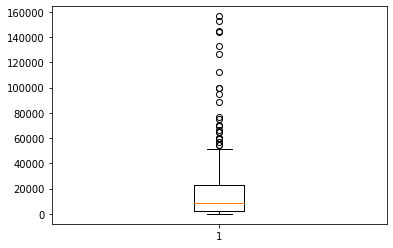

In [32]:
plt.boxplot(unique_stations_end.end_count)

###  Group Rides by Pick-Up Stations

In [33]:
unique_stations_start =count_pickup_df.groupby(["start_station_name"]).agg({'count':'sum','start_station_latitude':'mean','start_station_longitude':'mean'})
unique_stations_start = unique_stations_start.reset_index() 
unique_stations_start = unique_stations_start.rename(columns={'count': 'start_count'})

unique_stations_start.sort_values(by='start_count', ascending=False).head(10)

,start_station_name,start_count,start_station_latitude,start_station_longitude
272,Market St at 10th St,135174,37.77661900,-122.41738500
110,Berry St at 4th St,128886,37.77588000,-122.39317000
358,San Francisco Caltrain (Townsend St at 4th St),120906,37.77659800,-122.39528200
362,San Francisco Ferry Building (Harry Bridges Pl...,117048,37.79539200,-122.39420300
360,San Francisco Caltrain Station 2 (Townsend St...,109728,37.77663920,-122.39552630
298,Montgomery St BART Station (Market St at 2nd St),108243,37.78962540,-122.40081100
333,Powell St BART Station (Market St at 4th St),102759,37.78637527,-122.40490437
391,Steuart St at Market St,97344,37.79413000,-122.39443000
233,Howard St at Beale St,94023,37.78975600,-122.39464300
334,Powell St BART Station (Market St at 5th St),91743,37.78389936,-122.40844488


{'whiskers': [<matplotlib.lines.Line2D at 0x7fca54424690>,
 'caps': [<matplotlib.lines.Line2D at 0x7fca54422150>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fca54427150>],
 'medians': [<matplotlib.lines.Line2D at 0x7fca5441db50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fca5441d0d0>],
 'means': []}

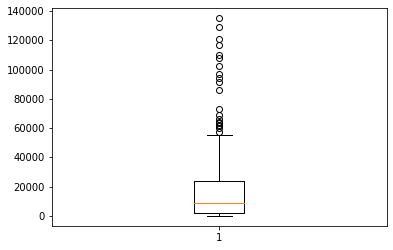

In [34]:
plt.boxplot(unique_stations_start.start_count)

### Concat both DF

#### Error Rectified
> Dataframe of unique start and end stations with their respective field attributes, with a length of 446 rows.

In [35]:
counting_stations_df = pd.merge(unique_stations_end, unique_stations_start, left_on='end_station_name',right_on='start_station_name')

print(len(counting_stations_df)) # 446 rows. Sounds about right!

446


### Further cleaning:

* Some typos in the name of stations is creating duplication (see example below); thus my objective will be to identify stations by matching lat and long coordinates:
![error](img/typo.png)

Yet this caused a great deal of confusion, mainly because when I attempted to identify rows with matching lat/long
for a station's type (pick-up or drop-off), I was not returning Woolsey St at Sacramento. I couldn't understand why, until I realized that the float values of my coordinates were rounded, and that matches had to be exact. Thus, my lat/long appeared to be matching, but by setting the precisions of the decimal display to a higher number, we can finally observe the source of confusion:
![error](img/precision.png)

Therefore, all of my coordinate fields had to be rounded-up uniformly so that I could match possible duplicates.

In [36]:
cols = ['start_station_latitude', 'start_station_longitude','end_station_latitude','end_station_longitude']
counting_stations_df[cols] = counting_stations_df[cols].round(6)

* Furthermore, the lat/long location ought to be unique per station, regardless of their designation as either pick-up or drop-off locations. The objective will be to identify mismatch in coordinates between pick-up and drop-off locations, and average coordinates if they differ.

#### Identify pick-up stations with duplicates

In [37]:
counting_stations_df[counting_stations_df[cols[0:1]].duplicated(keep = False) == True]

,end_station_name,end_count,end_station_latitude,end_station_longitude,start_station_name,start_count,start_station_latitude,start_station_longitude
4,10th St at University Ave,10788,37.869060,-122.293400,10th St at University Ave,6408,37.869060,-122.293400
13,16th Depot Bike Fleet Station,183,0.000000,0.000000,16th Depot Bike Fleet Station,33,0.000000,0.000000
109,Berkeley Civic Center,24261,37.869060,-122.270556,Berkeley Civic Center,20643,37.869060,-122.270556
349,SF Test Station,57,0.000000,0.000000,SF Test Station,3,0.000000,0.000000
443,Woolsey St at Sacramento St,14748,37.850578,-122.278175,Woolsey St at Sacramento St,13317,37.850578,-122.278175
444,Woolsey St at Sacramento St1,24,37.850578,-122.278175,Woolsey St at Sacramento St1,21,37.850578,-122.278175


#### Identify drop-off stations with duplicates

In [38]:
counting_stations_df[counting_stations_df[cols[2:4]].duplicated(keep = False) == True]

,end_station_name,end_count,end_station_latitude,end_station_longitude,start_station_name,start_count,start_station_latitude,start_station_longitude
13,16th Depot Bike Fleet Station,183,0.000000,0.000000,16th Depot Bike Fleet Station,33,0.000000,0.000000
349,SF Test Station,57,0.000000,0.000000,SF Test Station,3,0.000000,0.000000
443,Woolsey St at Sacramento St,14748,37.850578,-122.278175,Woolsey St at Sacramento St,13317,37.850578,-122.278175
444,Woolsey St at Sacramento St1,24,37.850578,-122.278175,Woolsey St at Sacramento St1,21,37.850578,-122.278175


#### Merge rows with matching coordinates

In [39]:
aggregation_functions = {'end_count': 'sum', 'start_count': 'sum', 'end_station_name': 'first','start_station_name':'first'}

i = [443,444]

new_row = counting_stations_df.loc[i].groupby(['end_station_latitude','end_station_longitude','start_station_latitude','start_station_longitude']).aggregate(aggregation_functions).reset_index()

counting_stations_df = counting_stations_df.append(new_row, ignore_index=True).drop(i)

#### Only the start station's latitude matches for this location, hence the groupby query has been modified.
aggregation_functions = {'end_count': 'sum', 'start_count': 'sum', 'end_station_name': 'first','start_station_name':'first','end_station_latitude':'mean','start_station_longitude':'mean','end_station_longitude':'mean'}

i = [4,109]

new_row = counting_stations_df.loc[i].groupby(['start_station_latitude']).aggregate(aggregation_functions).reset_index()

counting_stations_df = counting_stations_df.append(new_row, ignore_index=True).drop(i)

#### Drop 'Null' locations

In [40]:
i = [13,349]
counting_stations_df = counting_stations_df.drop(i)

#### Identify stations with drop-off and pick-up coordinates that do not match

    Upon reflection, it's not necessary to define a 'unique set' of coordinate for any given station; this was mostly in the interest of consistency when processing the datapoints in QGIS. However we can assume reasonably that slight differences in the coordinates between 'pick-up' and 'drop-off' stations will not affect the "true" location of the station when intersected with city or neighborhood boundaries.

In [41]:
len(counting_stations_df)

cols = ['start_station_latitude', 'start_station_longitude','end_station_latitude','end_station_longitude']

counting_stations_df['lat_diff'] = np.where(counting_stations_df[cols[0]] == counting_stations_df[cols[2]], 'same', 'different')
counting_stations_df['long_diff'] = np.where(counting_stations_df[cols[1]] == counting_stations_df[cols[3]], 'same', 'different')

counting_stations_df.head()

,end_station_name,end_count,end_station_latitude,end_station_longitude,start_station_name,start_count,start_station_latitude,start_station_longitude,lat_diff,long_diff
0,10th Ave at E 15th St,2553,37.792714,-122.248780,10th Ave at E 15th St,2631,37.792714,-122.248780,same,same
1,10th St at Empire St,639,37.349426,-121.887619,10th St at Empire St,732,37.349426,-121.887619,same,same
2,10th St at Fallon St,12231,37.797673,-122.262997,10th St at Fallon St,11121,37.797673,-122.262997,same,same
3,10th St at Mission St,1356,37.355693,-121.892251,10th St at Mission St,1629,37.355693,-121.892251,same,same
5,11th St at Bryant St,38163,37.770030,-122.411726,11th St at Bryant St,31590,37.770030,-122.411726,same,same


### 4. Save to csv and export to QGIS to intersect the station datapoints w/city/neighorhood boundaries

In [14]:
# counting_stations_df.to_csv('outputs/to_gis.csv') 

## Data Processing in QGIS

### Import CSVs which have been intersected with the boundaries of cities and SF neighborhoods in QGIS

Plotting the stations on QGIS allowed to observe a few outlier/dummy values to remove from the dataset:

![QGIS1](img/del1.png)

> Note that some dummy variables, such as locations with lat/long of 0, where already dropped over the second iteration of wrangling.
Another suitable method within Python to drop features that are out of proper geographic bounds would be to plot the lat and long of datapoints on a point data plot, and identify the outliers to exclude.

![QGIS2](img/del2.png)

The dataframe was imported into QGIS as a csv, and mapped as points with the end station's lat and long coordinates. Those points were overlaid with the shapefile layer of city boundaries for San Francisco (orange), the East Bay (purple) constituting of Oakland, Berkeley, and Emeryville, & San Jose (green).

Using the intersect function from the geoprocessing tool menu, each datapoint were intersected with their respective intersecting boundaries, capturing those boundaries' attribute features (namely, city's names and, additionally for San Francisco, the names of neighborhood's boundaries).

![QGIS3](img/Q_overlay.png)

Baywheels' stations from the 2019 annual dataset overlaid on San Francisco's neighborhoods.

![QGIS4](img/Q_sf_intersect.png)

## Re-importing the intersected dataset

In [42]:
%%time

path = r'./inputs/modifiedFiles' # use your path
files = glob.glob(path + "/*.csv")

li = []

for file in files:
    df = pd.read_csv(file, index_col=None, header=0)
    df = pd.DataFrame(df)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True, sort=False)
frame = frame.rename(columns={'name': 'city', 'n_name': 'SF_Neigh','end_statio':'end_station',
                             'end_stat_1':'end_lat','end_stat_2':'end_lon',
                             'start_st_1':'start_lat','start_st_2':'start_lon',
                             'start_coun':'start_C','end_count':'end_C','start_stat':'start_station',
                             })

frame = frame.drop('field_1',axis=1)

print(frame.dtypes)
print('---------------')
print(frame.shape)
print('---------------')

frame.head()

end_station       object
end_C              int64
end_lat          float64
end_lon          float64
start_station     object
start_C            int64
start_lat        float64
start_lon        float64
lat_diff          object
long_diff         object
SF_Neigh          object
city              object
dtype: object
---------------
(440, 12)
---------------
CPU times: user 240 ms, sys: 16 ms, total: 256 ms
Wall time: 257 ms


,end_station,end_C,end_lat,end_lon,start_station,start_C,start_lat,start_lon,lat_diff,long_diff,SF_Neigh,city
0,11th St at Bryant St,38163,37.770030,-122.411726,11th St at Bryant St,31590,37.770030,-122.411726,same,same,South of Market,San Francisco
1,11th St at Natoma St,38580,37.773507,-122.416040,11th St at Natoma St,36849,37.773507,-122.416040,same,same,South of Market,San Francisco
2,14th Ave at Geary Blvd,612,37.780471,-122.472823,14th Ave at Geary Blvd,522,37.780471,-122.472823,same,same,Inner Richmond,San Francisco
3,14th St at Mission St,20079,37.768265,-122.420110,14th St at Mission St,20922,37.768265,-122.420110,same,same,Mission,San Francisco
4,15th St at Potrero Ave,24726,37.767079,-122.407359,15th St at Potrero Ave,24966,37.767079,-122.407359,same,same,Showplace Square,San Francisco


## Insights

### Distribution of stations per city (Bay Wheels dataset)

#### Using Helper Functions to speed-up the process! 

Storing the code into a .py file

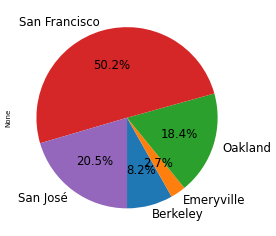

In [43]:
from pieMaker import * # (dataframe / attribute feature to groupby / piechart's dimensions)

pieMaker(frame,'city',(6,6))

Filter the dataframe down to stations in San Francisco only.

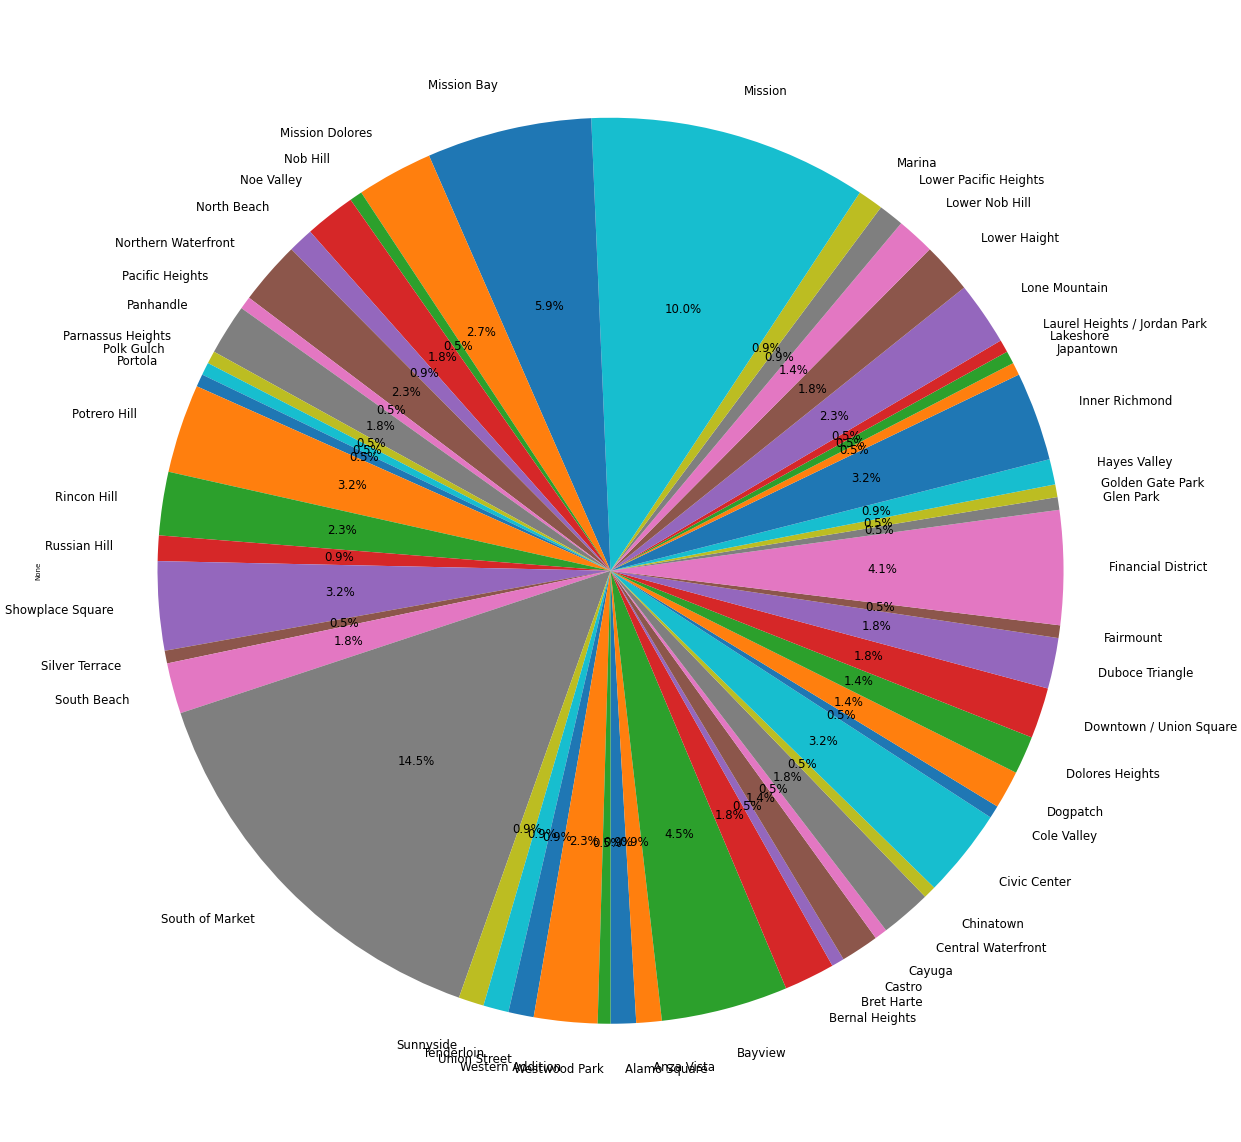

In [44]:
frame_sf = frame.loc[frame['city']=='San Francisco']
pieMaker(frame_sf,'SF_Neigh',(30,30))

<b>We're only interested in insights for the city of San Francisco, which accounts for half of Bay Wheels' 2019 Dataset</b>

In [45]:
frame_sf = frame.loc[frame['city']=='San Francisco']

print('There are ' + str(len(frame_sf)) + ' unique stations in San Francisco')

There are 221 unique stations in San Francisco


## Busiest 10 Pick-Up Station

In [46]:
frame_sf['start_P'] = (frame_sf['start_C'] / frame_sf['start_C'].sum()).astype(float).map("{:.2%}".format)

frame_sf.sort_values(by = ['start_C'],ascending=False).set_index(['start_station','SF_Neigh','start_P'])['start_C'].head(10)

/home/hp-nunes/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


start_station                                              SF_Neigh                 start_P
Market St at 10th St                                       South of Market          2.49%      135174
Berry St at 4th St                                         Mission Bay              2.38%      128886
San Francisco Caltrain (Townsend St at 4th St)             Mission Bay              2.23%      120906
San Francisco Ferry Building (Harry Bridges Plaza)         Financial District       2.16%      117048
San Francisco Caltrain Station 2  (Townsend St at 4th St)  Mission Bay              2.02%      109728
Montgomery St BART Station (Market St at 2nd St)           Financial District       2.00%      108243
Powell St BART Station (Market St at 4th St)               South of Market          1.90%      102759
Steuart St at Market St                                    Financial District       1.80%       97344
Howard St at Beale St                                      South of Market          1.74%   

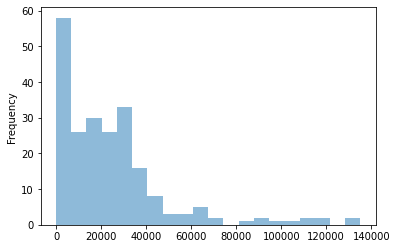

In [47]:
frame_sf['start_C'].plot.hist(bins=20, alpha=0.5)

## 10 Busiest Neighborhoods by Pick-Ups 

In [48]:
x = pd.DataFrame((frame_sf.groupby(['SF_Neigh'])['start_C'].sum() / frame_sf['start_C'].sum()).
                 astype(float).map("{:.2%}".format)).reset_index().rename(columns={'start_C':'startN_P'})

frame_sf = pd.merge(frame_sf, x, right_on='SF_Neigh',left_on='SF_Neigh').rename(columns={'startN_P_y':'startN_P'})

frame_sf.groupby(['SF_Neigh','startN_P'])['start_C'].sum().sort_values(ascending=False).head(10)

SF_Neigh                 startN_P
South of Market          20.78%      1126017
Mission Bay              12.35%       669141
Mission                  10.61%       574788
Financial District       10.36%       561132
Showplace Square         4.28%        231762
Rincon Hill              3.97%        215292
Downtown / Union Square  3.70%        200550
Northern Waterfront      3.55%        192624
Civic Center             2.80%        151623
Potrero Hill             2.34%        126684
Name: start_C, dtype: int64

## Busiest 10 Drop-Off Station

In [49]:
frame_sf['end_P'] = (frame_sf['end_C'] / frame_sf['end_C'].sum()).astype(float).map("{:.2%}".format)

frame_sf.sort_values(by = ['end_C'],ascending=False).set_index(['end_station','SF_Neigh','end_P'])['end_C'].head(10)

end_station                                                SF_Neigh                 end_P
San Francisco Caltrain Station 2  (Townsend St at 4th St)  Mission Bay              2.89%    156438
San Francisco Caltrain (Townsend St at 4th St)             Mission Bay              2.82%    152829
San Francisco Ferry Building (Harry Bridges Plaza)         Financial District       2.67%    144540
Montgomery St BART Station (Market St at 2nd St)           Financial District       2.65%    143658
Market St at 10th St                                       South of Market          2.45%    132852
Berry St at 4th St                                         Mission Bay              2.34%    126693
Powell St BART Station (Market St at 4th St)               South of Market          2.08%    112398
Steuart St at Market St                                    Financial District       1.85%     99957
The Embarcadero at Sansome St                              Northern Waterfront      1.84%     99858
Powell St 

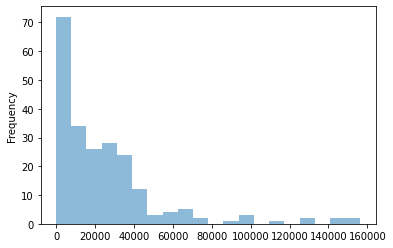

In [50]:
frame_sf['end_C'].plot.hist(bins=20, alpha=0.5)

## 10 Busiest Neighborhoods by Drop-offs 

In [51]:
x = pd.DataFrame((frame_sf.groupby(['SF_Neigh'])['end_C'].sum() / frame_sf['end_C'].sum()).
                 astype(float).map("{:.2%}".format)).reset_index().rename(columns={'end_C':'endN_P'})

frame_sf = pd.merge(frame_sf, x, right_on='SF_Neigh',left_on='SF_Neigh').rename(columns={'endN_P_y':'endN_P'})

frame_sf.groupby(['SF_Neigh','endN_P'])['end_C'].sum().sort_values(ascending=False).head(10)

SF_Neigh                 endN_P
South of Market          21.01%    1137603
Mission Bay              13.83%     748824
Financial District       11.67%     632007
Mission                  11.01%     596355
Showplace Square         4.78%      258987
Northern Waterfront      3.88%      209883
Rincon Hill              3.80%      205617
Downtown / Union Square  3.76%      203658
Civic Center             2.73%      147597
Potrero Hill             2.39%      129258
Name: end_C, dtype: int64

## Busiest Routes

In [52]:
count_trips_df['route'] = "From " + count_trips_df.start_station_name.map(str) + " to " + count_trips_df.end_station_name

routes_df = count_trips_df.groupby(['route','start_station_name','end_station_name','count']).nunique()
routes_df = routes_df.drop(routes_df[['end_station_name','start_station_name','start_station_latitude','start_station_longitude',
         'end_station_latitude','end_station_longitude','count','route']], axis=1)
routes_df = routes_df.reset_index()


### Merge San Francisco's Neighborhoods to unique start/end stations
Neigh_merge_s = frame_sf.groupby(['SF_Neigh','start_station']).nunique()
Neigh_merge_e = frame_sf.groupby(['SF_Neigh','end_station']).nunique()

Neigh_merge_s = Neigh_merge_s[['SF_Neigh','start_station']].drop(Neigh_merge_s[['SF_Neigh','start_station']],axis=1).reset_index()
Neigh_merge_e = Neigh_merge_e[['SF_Neigh','end_station']].drop(Neigh_merge_e[['SF_Neigh','end_station']],axis=1).reset_index()

routesDF1 = pd.merge(left=Neigh_merge_s, right=routes_df, left_on='start_station', right_on='start_station_name').rename(columns={'SF_Neigh':'SF_Neigh_start','count':'route_C'})
routesDF = pd.merge(left=Neigh_merge_e, right=routesDF1, left_on='end_station', right_on='end_station_name').rename(columns={'SF_Neigh':'SF_Neigh_end'})

routesDF = routesDF.drop(routesDF[['start_station']],axis=1)
###

### Find the Percentage
routesDF['route_P'] = (routesDF['route_C'] / routesDF['route_C'].sum()).astype(float).map("{:.2%}".format)
###

routesDF['route_Districts'] = "From " + routesDF.SF_Neigh_start.map(str) + " to " + routesDF.SF_Neigh_end


print(len(routesDF))
# routesDF.sort_values(['route_C'],ascending=False).head(10)

routesDF.groupby('route_Districts')['route_C'].sum().reset_index().sort_values(['route_C'],ascending=False).head(10)
routesDF

35623


,SF_Neigh_end,end_station,SF_Neigh_start,route,start_station_name,end_station_name,route_C,route_P,route_Districts
0,Alamo Square,Alamo Square (Steiner St at Fulton St),Alamo Square,From Alamo Square (Steiner St at Fulton St) to...,Alamo Square (Steiner St at Fulton St),Alamo Square (Steiner St at Fulton St),133,0.01%,From Alamo Square to Alamo Square
1,Alamo Square,Alamo Square (Steiner St at Fulton St),Alamo Square,From Grove St at Divisadero to Alamo Square (S...,Grove St at Divisadero,Alamo Square (Steiner St at Fulton St),28,0.00%,From Alamo Square to Alamo Square
2,Alamo Square,Alamo Square (Steiner St at Fulton St),Anza Vista,From O'Farrell St at Divisadero St to Alamo Sq...,O'Farrell St at Divisadero St,Alamo Square (Steiner St at Fulton St),28,0.00%,From Anza Vista to Alamo Square
3,Alamo Square,Alamo Square (Steiner St at Fulton St),Anza Vista,From O'Farrell St at Masonic Ave to Alamo Squa...,O'Farrell St at Masonic Ave,Alamo Square (Steiner St at Fulton St),1,0.00%,From Anza Vista to Alamo Square
4,Alamo Square,Alamo Square (Steiner St at Fulton St),Bernal Heights,From 29th St at Tiffany Ave to Alamo Square (S...,29th St at Tiffany Ave,Alamo Square (Steiner St at Fulton St),7,0.00%,From Bernal Heights to Alamo Square
...,...,...,...,...,...,...,...,...,...
35618,Western Addition,Turk St at Fillmore St,Western Addition,From Scott St at Golden Gate Ave to Turk St at...,Scott St at Golden Gate Ave,Turk St at Fillmore St,69,0.00%,From Western Addition to Western Addition
35619,Western Addition,Turk St at Fillmore St,Western Addition,From Turk St at Fillmore St to Turk St at Fill...,Turk St at Fillmore St,Turk St at Fillmore St,85,0.00%,From Western Addition to Western Addition
35620,Westwood Park,Frida Kahlo Way at Cloud Cir,Civic Center,From Market St at Franklin St to Frida Kahlo W...,Market St at Franklin St,Frida Kahlo Way at Cloud Cir,1,0.00%,From Civic Center to Westwood Park
35621,Westwood Park,Frida Kahlo Way at Cloud Cir,Sunnyside,From Judson Ave at Gennessee St to Frida Kahlo...,Judson Ave at Gennessee St,Frida Kahlo Way at Cloud Cir,1,0.00%,From Sunnyside to Westwood Park


In [ ]:
# routesDF.to_csv('outputs/routes_dataset.csv') 

In [53]:
print(routesDF.shape)
# routesDF.groupby(['route_Districts']).size().reset_index(name='counts').sort_values('counts',ascending=False)


new_df=routesDF.groupby(['SF_Neigh_start', 'SF_Neigh_end'])['route_C'].sum().reset_index(name='counts').sort_values(by='counts',ascending=False)
new_df.head(10)

(35623, 9)


,SF_Neigh_start,SF_Neigh_end,counts
1908,South of Market,South of Market,102965
1165,Mission,Mission,61677
1892,South of Market,Mission Bay,61676
1232,Mission Bay,South of Market,51383
1203,Mission Bay,Financial District,49166
682,Financial District,Mission Bay,47852
1183,Mission,South of Market,33688
1879,South of Market,Financial District,33088
1891,South of Market,Mission,29946
699,Financial District,South of Market,27446


## Total number of routes by Neighborhoods

In [54]:
routes_N = routesDF.groupby('SF_Neigh_end')[['route_C']].sum()

### Find the Percentage
routes_N['routeN_P'] = (routes_N['route_C'] / routes_N['route_C'].sum()).astype(float).map("{:.2%}".format)
###

routes_N.sort_values(['route_C'],ascending=False).head(10)

,route_C,routeN_P
SF_Neigh_end,,
South of Market,377029,21.01%
Mission Bay,248246,13.84%
Financial District,209531,11.68%
Mission,197713,11.02%
Showplace Square,85883,4.79%
Northern Waterfront,69710,3.89%
Rincon Hill,68077,3.79%
Downtown / Union Square,67508,3.76%
Civic Center,48917,2.73%
